<a href="https://colab.research.google.com/github/aebongbing/ESAA/blob/main/ESAA_%ED%95%84%EC%82%AC%EA%B3%BC%EC%A0%9C_0527.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 합성곱 신경망(CNN)

- CNN: 데이터가 가진 특징들의 패턴을 학습하는 알고리즘

## 1-1 이미지 표현

- 이미지는 컴퓨터가 이해할 수 있게 하기 위해 숫자로 표현됨

- RGB인 경우 한 차원이 더 추가된다

## 1-2 합성곱(Convolution)

- 합성곱 연산은 이미지에 대해 정방형 크기를 가지는 커널을 사용하여 입력 이미지에 대한 특성을 추출하는 방법

- 합성곱 연산을 통해 추출된 이미지를 특성맵(feature map)이라고 부른다

- 커널 사이즈가 3x3일 경우, 9개의 가중치를 가지며 오차 역전파 시 커널의 가중치를 업데이트한다

- 합성곱 신경망이 이미지 특성 추출에 효율적인 이유는 바로 커널의 공유 가중치 때문이다. 오차 역전파 시 커널의 그래디언트를 계산할 때 9개에 대해서만 업데이트하면 되므로 Fully Connencted Layer를 사용할 때보다 연산량이 훨씬 적다

##1-3 채널

- 채널: 입력 이미지를 구성하는 2차원의 배열 개수, 컬러 이미지의 경유 Red, Green, Blue 채널 이미지 3장이 겹쳐서 표현된다.

##1-4 스트라이드(stride)

- 스트라이드: 좌측 상단에서부터 입력 이미지를 기준으로 우측으로 이동하면서 합성곱 연산을 계속 수행하고 특성맵에 결과를 채워나간다. 이때 이동하는 간격을 스트라이드로 정의하며 주로 1 또는 2로 정의한다.

##1-5 패딩

- 특성맵의 크기가 줄어드는 것을 방지하기 위해 패딩을 사용 주로 zero-padding을 사용함

- 텐서플로 케라스의 Conv2D레이어에서 padding='same'으로 설정하면 zero-padding을 적용함 기본값은 padding='valid'이다

##1-6 특성맵 사이즈

- Image Height, Image Width: 입력 크기

- Kernel Height, Kernel Width: 필터 크기

- S: 스트라이드

- P: 패딩

- Output Height, Output Width: 출력 크기

##1-7 풀링

- 풀링 레이어는 추출된 특성맵에 대해 다운샘플링하여 이미지의 크기를 축소하는 레이어

- 장점: 이미지 축소를 통해 연산량 감소, 오버피팅 방지

- 종류: Maxpooling, AveragePooling

#2. 간단한 모델 생성

- MNIST 손글씨 데이터셋을 가지고 간단한 구조의 합성곱 신경망 모델을 만들어보자

## 2-1 데이터 로드 및 전처리

In [ ]:
#tensorflow 모듈 import
import tensorflow as tf

In [ ]:
#mnist 손글씨 이미지 데이터 로드
mnist=tf.keras.datasets.mnist
(x_train,y_train),(x_valid,y_valid)=mnist.load_data()

print(x_train.shape,y_train.shape)
print(x_valid.shape,y_valid.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


- train 데이터셋의 첫번째 이미지 출력

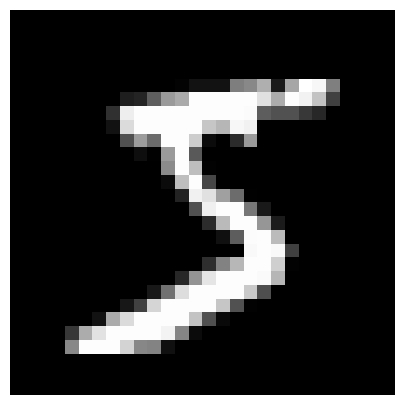

In [ ]:
#샘플 이미지 출력
import matplotlib.pyplot as plt

def plot_image(data, idx):
  plt.figure(figsize=(5,5))
  plt.imshow(data[idx], cmap='gray')
  plt.axis('off')
  plt.show()

plot_image(x_train, 0)

In [ ]:
print(x_train.min(), x_train.max())
print(x_valid.min(), y_valid.max())
#이미지 픽셀이 0~255 범위의 숫자로 구성된 것을 알 수 있다

0 255
0 9


- mnist 데이터셋은 색상을 나타내는 채널이 1개인 모노 컬러 이미지로 구성됨. CNN 모델에 주입하기 위해서 색상을 나타내는 채널을 추가해 준다

- 다음 코드는 tf.newaxis축을 텐서 배열에 직접 추가하는 방식이다. 따라서 (60000, 28, 28)형태의 텐서가 (60000, 28, 28, 1)형태로 변환됨


In [ ]:
#채널 추가
print(x_train.shape, x_valid.shape)

x_train_in=x_train[..., tf.newaxis]
x_valid_in=x_valid[..., tf.newaxis]

print(x_train_in.shape, x_valid_in.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)


##2-2 Sequential API 로 모델 생성 및 학습

- Sequential API를 이용해 합성곱 레이어 1개, 풀링 레이어 1개를 적용하는 간단한 모델을 만든다. 최종 분류기로 Dense 레이어를 적용하기 위해, Flatten층을 추가하여 2차원 배열로 펼쳐준다. 합성곱은 Conv2D레이어를 사용하고, (3,3)크기의 서로 다른 32가지 종류의 커널을 적용한다 ReLU활성화 함수를 적용한다. name 속성에 레이어의 이름을 'conv' 라고 지정해준다.

In [ ]:
#sequential API를 사용해 샘플 모델 생성
model=tf.keras.Sequential([
    # convolution 적용(32 filters)
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1), name='conv'),
    # Max Pooling 적용
    tf.keras.layers.MaxPooling2D((2,2), name='pool'),
    # Classifier 출력층
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

- 앞서 정의한 모델 구조에 옵키마이저, 손실함수, 평가지표를 설정한 후 컴파일하면 모델 인스턴스가 생성된다.

In [ ]:
#모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
#모델 훈련
history=model.fit(x_train_in, y_train, validation_data=(x_valid_in, y_valid), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.6043 - accuracy: 0.9390 - val_loss: 0.1187 - val_accuracy: 0.9688
Epoch 2/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0861 - accuracy: 0.9750 - val_loss: 0.0943 - val_accuracy: 0.9747
Epoch 3/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0701 - accuracy: 0.9788 - val_loss: 0.0902 - val_accuracy: 0.9752
Epoch 4/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0630 - accuracy: 0.9806 - val_loss: 0.1142 - val_accuracy: 0.9732
Epoch 5/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0543 - accuracy: 0.9835 - val_loss: 0.1106 - val_accuracy: 0.9749
Epoch 6/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0463 - accuracy: 0.9856 - val_loss: 0.1187 - val_accuracy: 0.9750
Epoch 7/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0385 - accuracy: 0.9879 - val_loss: 0.1877 -

- 훈련 셋과 검증 셋 모두 97%에 가까운 정확도를 보인다

In [ ]:
model.evaluate(x_valid_in,y_valid)
#각각 loss와 accuracy

313/313 [==============================] - 3s 8ms/step - loss: 0.1836 - accuracy: 0.9730


[0.1835615038871765, 0.9729999899864197]

- 훈련단계에서 훈련 결과를 history객체에 저장해 두었다. 10 epoch 동안 모델의 예측 정확도를 그래프로 그리는 함수를 정의하고 실행한다. 그래프를 보면 훈련 셋에 대한 손실은 계속 줄어드는데 검증셋의 손실은 어느 수준에서 더 이상 낮아지지 않는다. 4epoch 이후부터는 모델이 과대적합으로 진행되었다는 것을 파악할 수 있다

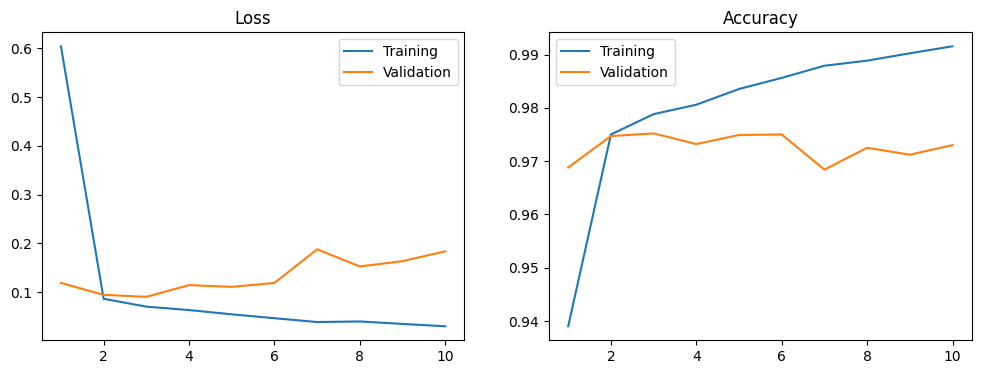

In [ ]:
def plot_loss_acc(history, epoch):
  loss, val_loss = history.history['loss'], history.history['val_loss']
  acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

  fig, axes = plt.subplots(1, 2, figsize=(12,4))
  axes[0].plot(range(1, epoch+1), loss, label='Training') # x축은 epoch, y축은 loss
  axes[0].plot(range(1, epoch+1), val_loss, label='Validation')# x축은 epoch, y축은 val_loss
  axes[0].legend(loc='best')
  axes[0].set_title('Loss')

  axes[1].plot(range(1, epoch+1), acc, label='Training')
  axes[1].plot(range(1, epoch+1), val_acc, label='Validation')
  axes[1].legend(loc='best')
  axes[1].set_title('Accuracy')

  plt.show()

plot_loss_acc(history, 10)

## 2-3 모델 구조 파악

- summary(): 모델의 구조를 요약해서 보여준다

- (28,28,1)형태의 입력 텐서가 Conv2D를 거치면서 (26,26,32) 형태로 변환된다. (3,3)크기의 합성곱 필터를 사용하므로 이미지 가로,세로 크기가 2씩 줄어든다. 여기서 패딩은 적용되지 않는다. 서로 다른 32개의 필터를 적용했기 때문여 (26,26)크기의 특성맵이 32개 생성된다. 즉, (28,28,1)이미지에 서로 다른 32개 커널을 적용해서 32가지 종류의 피처를 추출하는 것이다.
- (2,2)크기의 풀링 레이어를 적용했기 때문에 이미지 크기가 1/2로 줄어든다. 따라서 풀링 레이어를 거치면 (13,13,32)텐서로 변환되고, Flatten 중에서 3차원 텐서를 1차원 텐서로 펼치면 5408(13X13X32)개 원소를 갖는 1차원 벡터가 된다.

In [ ]:
#모델 구조
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv (Conv2D)               (None, 26, 26, 32)        320       
                                                                 
 pool (MaxPooling2D)         (None, 13, 13, 32)        0         
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 10)                54090     
                                                                 
Total params: 54410 (212.54 KB)
Trainable params: 54410 (212.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#입력 텐서 형태
model.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv_input')>

In [ ]:
#출력 텐서 형태
model.output

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense')>

In [ ]:
#레이어
model.layers
#4개의 레이어로 구성된다

In [ ]:
#첫번째 레이어
model.layers[0]
#리스트 인덱싱을 통해 첫 레이어를 선택가능

In [ ]:
#첫 번째 레이어 입력
model.layers[0].input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv_input')>

In [ ]:
#첫 번째 레이어 출력
model.layers[0].output

<KerasTensor: shape=(None, 26, 26, 32) dtype=float32 (created by layer 'conv')>

In [ ]:
# 첫 번째 레이어 가중치
model.layers[0].weights
# 커널 가중치의 shape는 (3,3,1,32)로, (3,3)은 필터의 크기, (1)은 입력층 채널 개수, (32)는 출력층의 채널 개수이다.
# layer[0]커널의 학습(업데이트) 가능한 파라미터 수는 3*3*1*32 = 288개이다.
# 상수항 가중치의 shape는(32, )이고, 이는 출력층의 채널 수를 말한다.
# layer[0]의 총 학습가능한 파라미터 수는 커널과 상수항을 더해서 288+32=320 개가 된다.

[<tf.Variable 'conv/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
 array([[[[-3.60283814e-02, -1.01447120e-01, -3.50773497e-03,
           -1.01924837e-02, -7.00204223e-02, -2.63825864e-01,
           -1.61065996e-01,  2.82326639e-02, -1.51030153e-01,
           -2.06383020e-02, -5.98631762e-02,  2.50179600e-02,
           -2.05986891e-02, -3.42261232e-02, -6.49694949e-02,
            4.93431045e-03, -1.24826372e-01, -8.28055944e-03,
            2.65853610e-02, -1.91065952e-01, -2.00222239e-01,
           -1.68395221e-01, -7.18403084e-04, -1.08718604e-01,
           -3.25755738e-02, -3.54108401e-02, -5.25090471e-02,
           -1.90677249e-03, -6.44282699e-02, -1.48794055e-01,
           -1.38388544e-01, -2.09239766e-01]],
 
         [[-1.35026783e-01,  1.46944821e-01, -4.60036956e-02,
           -8.03158358e-02, -3.83810839e-03,  7.57054389e-02,
            7.37412721e-02, -8.87937993e-02, -1.26485422e-01,
           -4.32799235e-02, -8.09775591e-02, -1.89071089e-01,
           

In [ ]:
# 첫 번째 레이어 커널 가중치
model.layers[0].kernel
# 이와 같이 커널 행렬의 가중치 또는 상수항을 따로 선택할 수 있다.

<tf.Variable 'conv/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
array([[[[-3.60283814e-02, -1.01447120e-01, -3.50773497e-03,
          -1.01924837e-02, -7.00204223e-02, -2.63825864e-01,
          -1.61065996e-01,  2.82326639e-02, -1.51030153e-01,
          -2.06383020e-02, -5.98631762e-02,  2.50179600e-02,
          -2.05986891e-02, -3.42261232e-02, -6.49694949e-02,
           4.93431045e-03, -1.24826372e-01, -8.28055944e-03,
           2.65853610e-02, -1.91065952e-01, -2.00222239e-01,
          -1.68395221e-01, -7.18403084e-04, -1.08718604e-01,
          -3.25755738e-02, -3.54108401e-02, -5.25090471e-02,
          -1.90677249e-03, -6.44282699e-02, -1.48794055e-01,
          -1.38388544e-01, -2.09239766e-01]],

        [[-1.35026783e-01,  1.46944821e-01, -4.60036956e-02,
          -8.03158358e-02, -3.83810839e-03,  7.57054389e-02,
           7.37412721e-02, -8.87937993e-02, -1.26485422e-01,
          -4.32799235e-02, -8.09775591e-02, -1.89071089e-01,
          -4.82544396e-03,  

In [ ]:
# 첫 번째 레이어 bias 가중치
model.layers[0].bias

<tf.Variable 'conv/bias:0' shape=(32,) dtype=float32, numpy=
array([-0.11068477, -0.01290403, -0.03931517, -0.15432115, -0.27728656,
       -0.01012437, -0.01122423, -0.0080237 , -0.01913277, -0.21226756,
       -0.32686073, -0.02247887, -0.4135727 , -0.05464425, -0.00728778,
       -0.20530397, -0.2846177 , -0.32985112, -0.15803406, -0.01228422,
       -0.02554493, -0.3829007 , -0.51020837, -0.01189274, -0.04715313,
        0.00234449, -0.1588792 , -0.68911105, -0.00769689, -0.41829947,
       -0.02395094, -0.22065333], dtype=float32)>

In [ ]:
# 레이어 이름 사용하여 레이어 선택
model.get_layer('conv')

- 모델에 입력 데이터를 넣어주고 모델의 첫 번째와 두번째 레이어의 출력을 최종 출력으로 갖는 activator모델을 정의한다. 첫번째 샘플에 대하여 각 레이어의 출력을 예측한다.

In [ ]:
# 샘플 이미지의 레이어별 출력을 리스트에 추가(첫번쨰, 두번째 레이어)
activator = tf.keras.Model(inputs= model.input,
                           outputs = [layer.output for layer in model.layers[:2]])
activations = activator.predict(x_train_in[0][tf.newaxis,...])
len(activations)

1/1 [==============================] - 0s 101ms/step


2

- 2개의 출력 텐서 중에서 첫번째 텐서는 Conv2D레이어의 출력이다. 텐서의 형태는 (1,26,26,32)인데, 여기서 1은 입력 이미지의 개수를 나타낸다. 샘플이 1개라는 뜻이다.

In [ ]:
# 첫번째 레이어(conv) 출력층
conv_activation = activations[0]
conv_activation.shape

(1, 26, 26, 32)

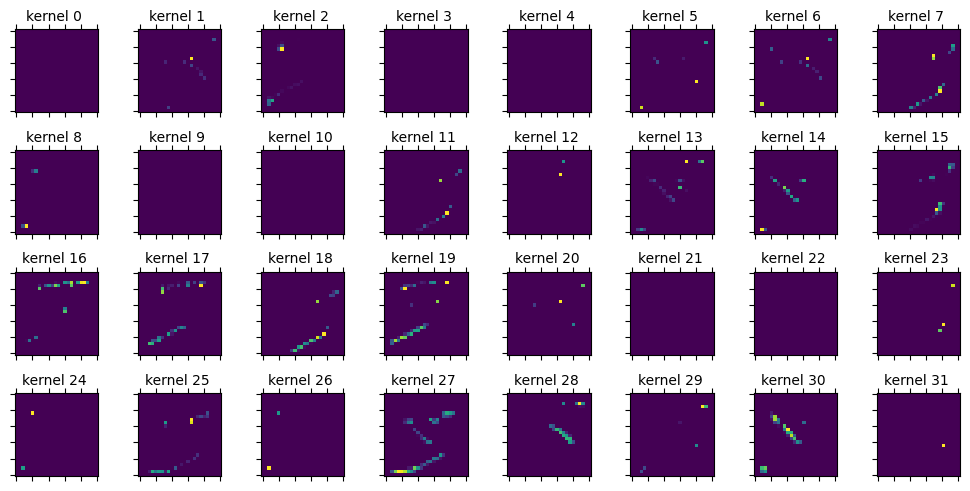

In [ ]:
# Convolution 시각화
import matplotlib.pyplot as plt
fig, axes = plt.subplots(4,8)
fig.set_size_inches(10,5)

for i in range(32):
  axes[i//8, i%8].matshow(conv_activation[0,:,:,i], cmap='viridis')
  axes[i//8, i%8].set_title('kernel %s '%str(i),fontsize=10)
  plt.setp(axes[i//8, i%8].get_xticklabels(), visible=False)
  plt.setp(axes[i//8, i%8].get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

- 두번째 레이어는 maxpooling 레이어이다. 여기서 출력하는 텐서는 (1,13,13,32)형태를 갖는다.

In [ ]:
pooling_activation = activations[1]
print(pooling_activation.shape)

(1, 13, 13, 32)


- 각 커널별로 출력되는 특성맵 이미지를 시각화하면 앞서 Conv2D출력 이미지에 비해 화소 크기가 굵어진 것을 볼 수 있다. 최대 풀링은 인근 픽셀들을 모아서 최대값으로 고정하기 때문에 픽셀 수는 줄이면서 특징을 더욱 강하게 드러낼 수 있다.

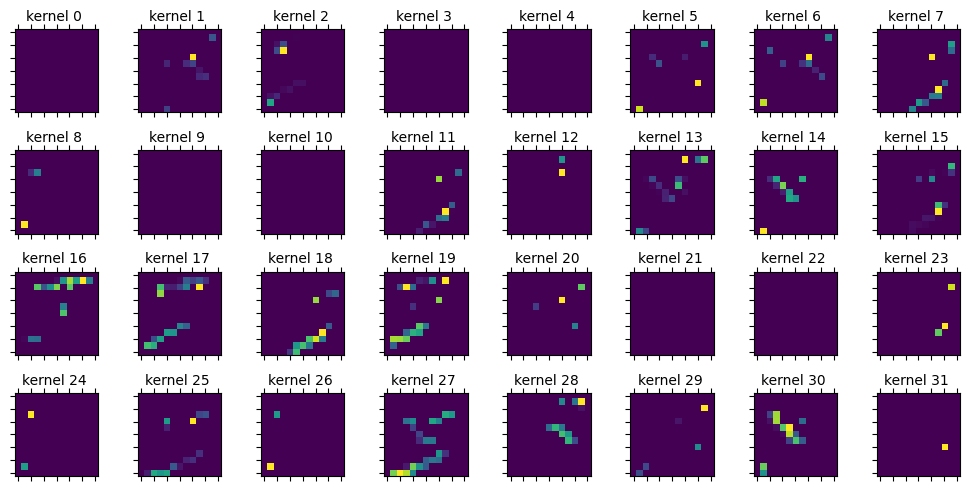

In [ ]:
# 시각화
fig,axes = plt.subplots(4,8)
fig.set_size_inches(10,5)

for i in range(32):
  axes[i//8, i%8].matshow(pooling_activation[0,:,:,i], cmap='viridis')
  axes[i//8, i%8].set_title('kernel %s '%str(i),fontsize=10)
  plt.setp(axes[i//8, i%8].get_xticklabels(), visible=False)
  plt.setp(axes[i//8, i%8].get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

## 3-1 데이터셋 준비

- 필요한 라이브러리와 mnist 데이터셋을 불러와서 훈련 데이터셋과 검증 데이터셋으로 구분하여 저장한다

In [ ]:
import numpy as np
import tensorflow as tf

# mnist 손글씨 이미지 데이터 로드
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


- 원본 mnist 데이터셋은 0~9의 숫자를 손글씨로 쓴 이미지(x)와 정답 (y)로 구성되어 있다. 우리는 홀짝을 맞추는 y_odd를 새로 만들어 추가한다. 다음과 같이 y_train값이 홀수이면 1, 짝수이면 0으로 하는 y_train_odd 배열을 새로 만든다.

In [ ]:
y_train_odd = []
for y in y_train:
  if y%2==0:
    y_train_odd.append(0)
  else:
    y_train_odd.append(1)
y_train_odd = np.array(y_train_odd)
y_train_odd.shape

(60000,)

In [ ]:
print(y_train[:10]) # 0~9 사이 숫자
print(y_train_odd[:10]) # 0 또는 1

[5 0 4 1 9 2 1 3 1 4]
[1 0 0 1 1 0 1 1 1 0]


- 검증 데이터셋에 대해서도 홀짝을 나타내는 y_valid_odd배열을 만든다.

In [ ]:
# validation 데이터셋 처리
y_valid_odd = []
for y in y_valid:
    if y % 2 == 0:
        y_valid_odd.append(0)
    else:
        y_valid_odd.append(1)

y_valid_odd = np.array(y_valid_odd)
y_valid_odd.shape

(10000,)

- 입력 이미지 데이터를 255로 나누어 정규화한다. 색상이 하나뿐인 이미지이므로 새로운 축을 추가하고 채널 개수를 1개로 지정한다.

- 텐서플로 expand_dims()함수에 원본 배열을 입력하고 새롭게 추가하려는 축의 인덱스를 지정하면 해당 인덱스에 새로운 축이 추가된다. 여기서는 축의 인덱스로 -1을 지정했기 때문에 새로운 축은 끝에 추가된다. 즉, (60000,28,28)배열이 (60000,28,28,1)배열이 된다.

In [ ]:
# 정규화(normalization)
x_train = x_train / 255.0
x_valid = x_valid / 255.0

# 채널 추가
x_train_in = tf.expand_dims(x_train, -1)
x_valid_in = tf.expand_dims(x_valid, -1)

print(x_train_in.shape, x_valid_in.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


##3-2. Function API로 다중 입력, 다중출력 레이어 생성

- Function API를 사용하면 사용자가 원하는 복잡한 구조의 모델을 만들 수 있다. 앞에서 다룬 Sequential API의 경우 레이어를 층층이 한 줄로 연결할 수밖에 없지만, Function API를 사용하면 다중 입력 또는 다중 출력 같은 구조를 만들 수 있다.

- 다음 코드에서 입력 레이어 input의 경우, Conv2D 레이어와 Flatten레이어의 입력으로 사용된다. 따라서 입력 레이어는 2개의 출력을 갖게 된다. 서로 다른 2개의 출력은 각각 다른 레이어의 입력으로 사용되고, 최종적으로 Concatenate레이어에서 합쳐진 다음에 Dense 레이어를 통과한다. 이처럼 함수의 입력과 출력으로 표현할 수 있어서 자유롭게 모델 구조를 정의할 수 있는 장점이 있다.

In [ ]:
# Functional API 를 사용하여 모델 생성

inputs = tf.keras.layers.Input(shape=(28,28,1))

conv = tf.keras.layers.Conv2D(16, (3,3), activation='relu')(inputs)
pool = tf.keras.layers.MaxPool2D(2,2)(conv)
flat = tf.keras.layers.Flatten()(pool)

flat_inputs = tf.keras.layers.Flatten()(inputs)
concat = tf.keras.layers.Concatenate()([flat, flat_inputs])
outputs = tf.keras.layers.Dense(10, activation='softmax')(concat)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 26, 26, 16)           160       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 13, 13, 16)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 flatten_1 (Flatten)         (None, 2704)                 0         ['max_pooling2d[0][0]'] 

- 앞서 정의한 모델 구조를 그래프로 출력하면 다음과 같다. 케라스 utils모듈의 plot_model을 사용하고, 모델을 입력하면 모델 구조를 그려준다.

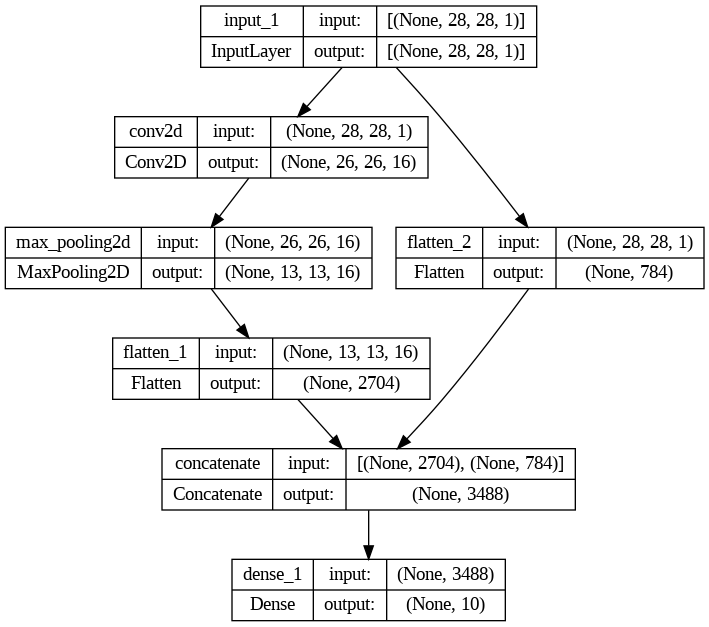

In [ ]:
# 모델 구조 출력 및 이미지 파일로 저장
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='functional_cnn.png')

In [ ]:
# 모델 컴파일
model.compile(optimizer= 'adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

# 모델 훈력
history = model.fit(x_train_in, y_train,
                    validation_data = (x_valid_in, y_valid),
                    epochs=10)

# 모델 성능
val_loss, val_acc = model.evaluate(x_valid_in, y_valid)
print(val_loss, val_acc)

Epoch 1/10
1875/1875 [==============================] - 28s 14ms/step - loss: 0.2200 - accuracy: 0.9382 - val_loss: 0.0971 - val_accuracy: 0.9718
Epoch 2/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0855 - accuracy: 0.9753 - val_loss: 0.0788 - val_accuracy: 0.9743
Epoch 3/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0645 - accuracy: 0.9811 - val_loss: 0.0656 - val_accuracy: 0.9783
Epoch 4/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0546 - accuracy: 0.9838 - val_loss: 0.0620 - val_accuracy: 0.9800
Epoch 5/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0468 - accuracy: 0.9859 - val_loss: 0.0576 - val_accuracy: 0.9813
Epoch 6/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0413 - accuracy: 0.9873 - val_loss: 0.0619 - val_accuracy: 0.9797
Epoch 7/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0360 - accuracy: 0.9891 - val_loss: 0.0558 -

##3-3 다중 출력 분류 모델

- 이번에는 두가지 서로 다른 분류 문제를 예측하는 출력모델을 만들어본다. 이진분류를 했던 앞과 달리 이번에는 0~9까지 숫자를 맞추는 분류 문제와 홀수,짝수를 맞추는 분류문제를 동시에 풀어내는 모델의 정의한다. 각기 다른 문제에 맞도록 최종 분류기의 출력 레이어를 2개 만드는 것이 핵심이다.

In [ ]:
# Functional API 를 사용해 모델 생성
inputs = tf.keras.layers.Input(shape=(28,28,1), name='inputs')

conv = tf.keras.layers.Conv2D(32, (3,3), activation='relu', name='conv2d_layer')(inputs)
pool = tf.keras.layers.MaxPool2D((2,2), name='maxpool_layer')(conv)
flat = tf.keras.layers.Flatten(name='flatten_layer')(pool)

flat_inputs = tf.keras.layers.Flatten()(inputs)
concat = tf.keras.layers.Concatenate()([flat, flat_inputs])
digit_outputs = tf.keras.layers.Dense(10, activation='softmax', name='digit_dense')(concat) # 다중분류
odd_outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='odd_dense')(flat_inputs) # 이진분류

model = tf.keras.Model(inputs=inputs, outputs=[digit_outputs, odd_outputs])
model.summary()

# 입력은 하나이다. 출력은 10개인 텐서와 1개인 텐서로, 총 2개가 확인된다.

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_layer (Conv2D)       (None, 26, 26, 32)           320       ['inputs[0][0]']              
                                                                                                  
 maxpool_layer (MaxPooling2  (None, 13, 13, 32)           0         ['conv2d_layer[0][0]']        
 D)                                                                                               
                                                                                                  
 flatten_layer (Flatten)     (None, 5408)                 0         ['maxpool_layer[0][0]'] 

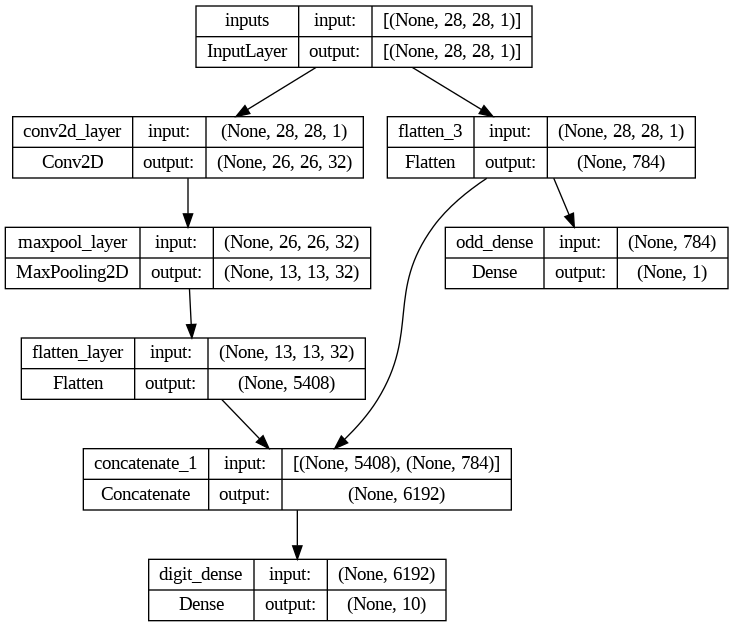

In [ ]:
# 모델 구조 그리기
plot_model(model, show_shapes=True, show_layer_names=True, to_file='multi_output_cnn.png')

In [ ]:
model.compile(optimizer= 'adam', loss={'digit_dense':'sparse_categorical_crossentropy',
                                       'odd_dense':'binary_crossentropy'},
              loss_weights = {'digit_dense': 1, 'odd_dense':0.5},
              #  loss = 1.0 * sparse_categorical_crossentropy + 0.5*binary_crossentropy
              metrics = ['accuracy'])

# 모델 훈련
history = model.fit({'inputs':x_train_in},
                    {'digit_dense':y_train,'odd_dense':y_train_odd},
                    validation_data=({'inputs':x_valid_in},
                    {'digit_dense':y_valid,'odd_dense':y_valid_odd}),
                    epochs=10)
# digit_dense, odd_dense 같은 이름을 지정하고 레이어 이름 속성을 key로 하는 딕셔너리 형태로
# 각각의 출력에 맞는 정답 배열을 입력해야 한다.
# 검증 데이터셋에 대해서도 마찬가지로 구분해 지정한다.

Epoch 1/10
1875/1875 [==============================] - 38s 19ms/step - loss: 0.3647 - digit_dense_loss: 0.2022 - odd_dense_loss: 0.3250 - digit_dense_accuracy: 0.9424 - odd_dense_accuracy: 0.8642 - val_loss: 0.2258 - val_digit_dense_loss: 0.0872 - val_odd_dense_loss: 0.2772 - val_digit_dense_accuracy: 0.9739 - val_odd_dense_accuracy: 0.8883
Epoch 2/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.2130 - digit_dense_loss: 0.0774 - odd_dense_loss: 0.2712 - digit_dense_accuracy: 0.9776 - odd_dense_accuracy: 0.8907 - val_loss: 0.1925 - val_digit_dense_loss: 0.0614 - val_odd_dense_loss: 0.2623 - val_digit_dense_accuracy: 0.9803 - val_odd_dense_accuracy: 0.8967
Epoch 3/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1905 - digit_dense_loss: 0.0592 - odd_dense_loss: 0.2627 - digit_dense_accuracy: 0.9824 - odd_dense_accuracy: 0.8963 - val_loss: 0.1923 - val_digit_dense_loss: 0.0620 - val_odd_dense_loss: 0.2606 - val_digit_dense_accuracy: 0.9799 -

- 숫자를 맞추는 문제는 98%의 정확도를 보이는 반면, 홀수여부를 판단하는 문제는 약 90%의 정확도를 보인다.

- 검증 데이터셋의 인덱스0에 해당하는 이미지 출력

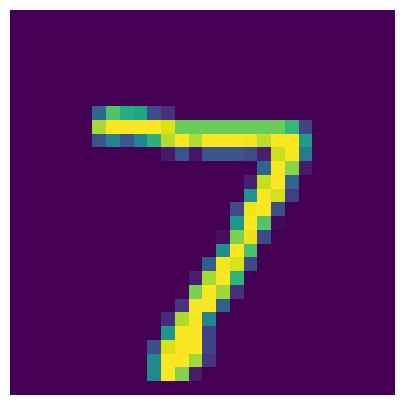

In [ ]:
# 샘플 이미지 출력
import matplotlib.pyplot as plt

def plot_image(data, idx):
  plt.figure(figsize=(5,5))
  plt.imshow(data[idx])
  plt.axis('off')
  plt.show()

plot_image(x_valid, 0)

In [ ]:
# 검증 데이터셋의 모든 이미지 데이터를 입력해 2개의 분류(다중,이진)에 대한 예측확률을 구하면 다음과 같다
digit_preds, odd_preds = model.predict(x_valid_in)
print(digit_preds[0]) # 10개 분류레이블에 대한 확률
print(odd_preds[0]) # 홀수일 확률

313/313 [==============================] - 3s 8ms/step
[2.9230099e-12 2.5544633e-09 1.7732980e-08 3.5361566e-07 1.8004476e-11
 1.6626751e-12 4.5442362e-20 9.9999958e-01 2.8235544e-10 1.2847007e-08]
[0.999491]


In [ ]:
digit_labels = np.argmax(digit_preds, axis=-1)
print(digit_labels[0:10])

[7 2 1 0 4 1 4 9 6 9]


In [ ]:
odd_labels = (odd_preds > 0.5).astype(np.int64).reshape(1,-1)[0]
print(odd_labels[0:10])

[1 0 1 0 0 1 0 1 0 1]


##3-4 전이학습

- 전이학습(Transfer Training) : 기존에 학습된 모델을 활용해 새로운 모델을 만들어내는 개념

- 앞에서 학습한 모델에서 입력 레이어부터 'flatten_layer'라는 name속성을 갖는 Flatten 층까지 해당하는 부분을 따로 추출하여, base_model 객체를 만든다. 모델 개요를 출력해서 확인해보면 (28,28,1) 이미지를 받아서 5408개의 피처로 특징을 추출해 출력하는 모델이다.

In [ ]:
# 앞의 모델에서 flatten_layer 출력을 추출
base_model_output = model.get_layer('flatten_layer').output

# 앞의 출력을 출력으로 하는 모델 정의
base_model = tf.keras.Model(inputs=model.input, outputs=base_model_output, name='base')
base_model.summary()

Model: "base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320 (1.25 KB)
Trainable params: 320 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


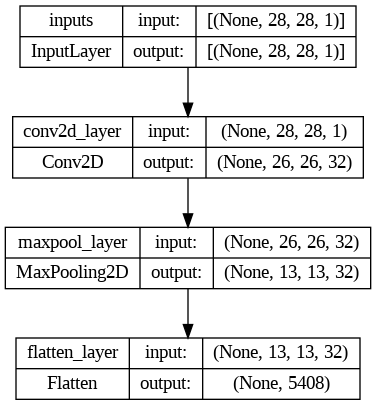

In [ ]:
# 모델 구조 시각화
plot_model(base_model, show_shapes=True, show_layer_names=True, to_file='base_model.png')

In [ ]:
# Sequential API 적용

# 새로 정의한 base_model을 레이어로 추가한 후 최종 분류기 역할을 하는 Dense레이어를 새롭게 이어준다.
digit_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(10, activation='softmax')
    ])
digit_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base (Functional)           (None, 5408)              320       
                                                                 
 dense_2 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54410 (212.54 KB)
Trainable params: 54410 (212.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


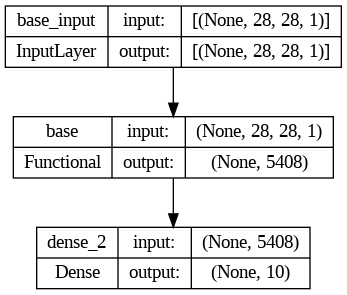

In [ ]:
# 모델 구조 출력 => 최종적으로 노드 10개를 가진 분류기 역할을 하는 Dense 레이어가 추가됨을 알 수 있다
plot_model(digit_model, show_shapes=True, show_layer_names=True, to_file='digit_model.png')

In [ ]:
# 모델 컴파일
digit_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# 모델 훈련
history = digit_model.fit(x_train_in, y_train,
                          validation_data=(x_valid_in, y_valid),
                          epochs=10)

Epoch 1/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1308 - accuracy: 0.9632 - val_loss: 0.0657 - val_accuracy: 0.9780
Epoch 2/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0590 - accuracy: 0.9816 - val_loss: 0.0552 - val_accuracy: 0.9820
Epoch 3/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0451 - accuracy: 0.9858 - val_loss: 0.0507 - val_accuracy: 0.9839
Epoch 4/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0355 - accuracy: 0.9892 - val_loss: 0.0528 - val_accuracy: 0.9828
Epoch 5/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0288 - accuracy: 0.9909 - val_loss: 0.0631 - val_accuracy: 0.9812
Epoch 6/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0246 - accuracy: 0.9920 - val_loss: 0.0631 - val_accuracy: 0.9816
Epoch 7/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0200 - accuracy: 0.9942 - val_loss: 0.0516 -

In [ ]:
# 베이스 모델의 가중치 고정(freeze model)
'''
모델 인스턴스는 trainable 속성을 가지고 있다.
이 속성을 False로 지정하면 모델의 파라미터 값이 고정되어 훈련을 통해 업데이트되지 않는다.
이런 방식으로 base_model_frozen을 구성한다. trainable params 개수가 0인 것을 아래서 확인 가능하다.
'''
base_model_frozen = tf.keras.Model(inputs=model.input,
                                   outputs=base_model_output,
                                   name='base_frozen')
base_model_frozen.trainable = False #
base_model_frozen.summary()

Model: "base_frozen"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320 (1.25 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 320 (1.25 KB)
_________________________________________________________________


- 이제, 파라미터를 고정한 base_model_input 모델과 새로운 분류기 역할을 하는 Dense 레이어를 Functional API를 적용하여 구성해본다. Sequential API로 구성하는 방식과의 차이점에 유의한다.


- 총 파라미터 개수는 54410개이고 앞서 고정한 파라미터는 훈련 불가능하다는 것이 표시되어 있다. 훈련 가능한 파라미터는 Flatten 레이어의 출력 5408개와 Dense 레이어의 10개 노드 사이의 가중치만 해당된다. 즉, Flatten레이어 이전에 존재하는 Conv2D레이어의 파라미터 320개는 포함되지 않는다.

In [ ]:
# functional API 적용
dense_output = tf.keras.layers.Dense(10, activation='softmax')(base_model_frozen.output)
digit_model_frozen = tf.keras.models.Model(inputs=base_model_frozen.input, outputs=dense_output)
digit_model_frozen.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54410 (212.54 KB)
Trainable params: 54090 (211.29 KB)
Non-trainable params: 320 (1.25 KB)
_____________________

In [ ]:
# 모델 컴파일
digit_model_frozen.compile(optimizer='adam',
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

# 모델 훈련
history = digit_model_frozen.fit(x_train_in, y_train,
                                 validation_data=(x_valid_in, y_valid),
                                 epochs=10)

Epoch 1/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1173 - accuracy: 0.9682 - val_loss: 0.0579 - val_accuracy: 0.9825
Epoch 2/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0487 - accuracy: 0.9857 - val_loss: 0.0628 - val_accuracy: 0.9801
Epoch 3/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0364 - accuracy: 0.9889 - val_loss: 0.0496 - val_accuracy: 0.9835
Epoch 4/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0290 - accuracy: 0.9914 - val_loss: 0.0557 - val_accuracy: 0.9822
Epoch 5/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0224 - accuracy: 0.9928 - val_loss: 0.0504 - val_accuracy: 0.9844
Epoch 6/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0191 - accuracy: 0.9938 - val_loss: 0.0576 - val_accuracy: 0.9834
Epoch 7/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0147 - accuracy: 0.9957 - val_loss: 0.0573 - val_ac

In [53]:
# 베이스 모델의 conv2d 레이어의 가중치만 고정(freeze layer)
base_model_frozen2 = tf.keras.Model(inputs=model.input, outputs=base_model_output, name='base_frozen2')
base_model_frozen2.get_layer('conv2d_layer').trainable = False
base_model_frozen2.summary()

Model: "base_frozen2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
Total params: 320 (1.25 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 320 (1.25 KB)
_________________________________________________________________


- 위에서 고정한 모델에 새로운 분류기 역할을 하는 Dense레이어를 연결하여 모델을 구성한다.

In [54]:
#functional API 적용
dense_output2 = tf.keras.layers.Dense(10,activation='softmax')(base_model_frozen2.output)
digit_model_frozen2 = tf.keras.models.Model(inputs=base_model_frozen2.input, outputs=dense_output2)
digit_model_frozen2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_layer (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 maxpool_layer (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten_layer (Flatten)     (None, 5408)              0         
                                                                 
 dense_6 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54410 (212.54 KB)
Trainable params: 54090 (211.29 KB)
Non-trainable params: 320 (1.25 KB)
_____________________

In [56]:
# 모델 컴파일
digit_model_frozen2.compile(optimizer='adam',
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])

# 모델 훈련
history = digit_model_frozen2.fit(x_train_in, y_train,
                                  validation_data=(x_valid_in, y_valid),
                                  epochs=10)

Epoch 1/10
1875/1875 [==============================] - 22s 10ms/step - loss: 0.1151 - accuracy: 0.9691 - val_loss: 0.0560 - val_accuracy: 0.9836
Epoch 2/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0501 - accuracy: 0.9850 - val_loss: 0.0505 - val_accuracy: 0.9840
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0363 - accuracy: 0.9887 - val_loss: 0.0497 - val_accuracy: 0.9838
Epoch 4/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0281 - accuracy: 0.9914 - val_loss: 0.0516 - val_accuracy: 0.9825
Epoch 5/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0231 - accuracy: 0.9927 - val_loss: 0.0557 - val_accuracy: 0.9831
Epoch 6/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0182 - accuracy: 0.9945 - val_loss: 0.0524 - val_accuracy: 0.9846
Epoch 7/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0155 - accuracy: 0.9955 - val_loss: 0.0608 - val_a